# Tratamento de Séries Temporais

## Importação das bibliotecas e configurações iniciais

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [406]:
# Data analysis in general
import pandas as pd
import numpy as np

# Statistics
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.api import VAR
import pmdarima as pm

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# For date manipulation
from datetime import timedelta

In [20]:
%matplotlib inline

In [152]:
pib = pd.read_excel('dados/PIB.xls')

pib = pib.iloc[:, 2:].T
pib.columns = ['PIB']

pib['Data'] = pib.index.astype('str')
pib['Data'] = pib['Data'].str.slice(0, 4) + '-' + pib['Data'].str.slice(4, 6) + '-' + pib['Data'].str.slice(6)
pib['Data'] = pd.to_datetime(pib['Data'])
pib = pib.set_index('Data')
pib['PIB'] = pib['PIB'] * 1000
# Os dados só são anuais a partir de 1985
pib = pib.loc['1985-01-01':] 

pib

,PIB
Data,
1985-01-01,1.819572e+12
1986-01-01,1.930043e+12
1987-01-01,2.039988e+12
1988-01-01,2.043433e+12
1989-01-01,2.076605e+12
1990-01-01,2.041445e+12
1991-01-01,2.078752e+12
1992-01-01,2.085247e+12
1993-01-01,2.189059e+12


<AxesSubplot:xlabel='Data'>

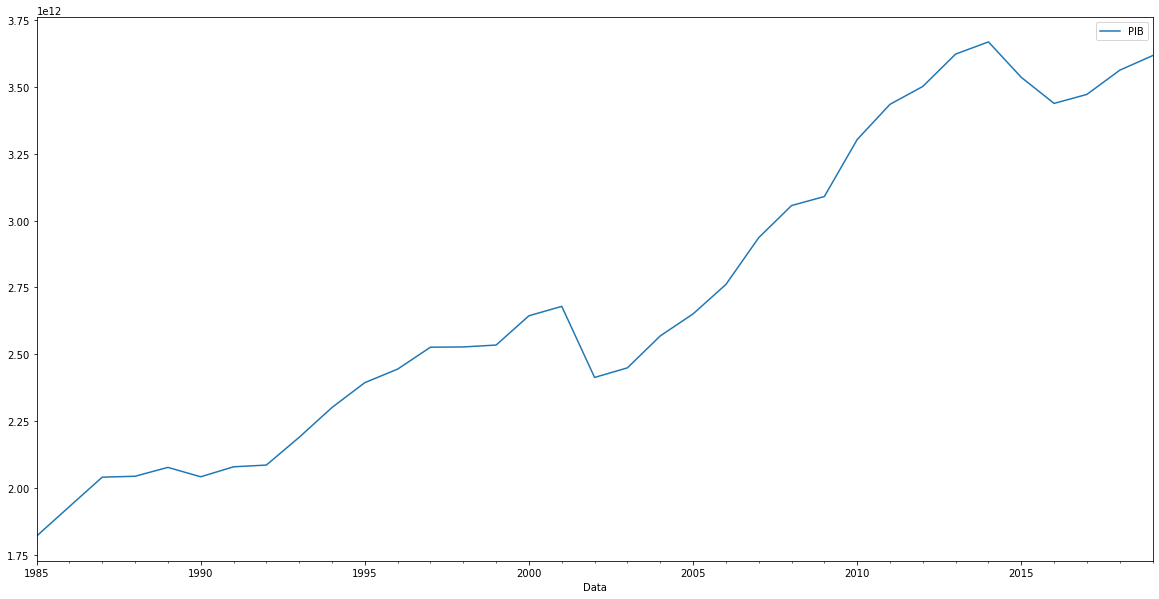

In [153]:
pib.plot(figsize=((20, 10)))

## Verificação de estacionariedade

Para uma série ser estacionária, sua média e variância devem ser constantes no tempo:

$$\bar{\mu} = f(tempo)$$
$$\bar{\sigma}^2 = f(tempo)$$

É interessante trabalhar com séries estacionárias pois a distribuição dos valores em uma série não-estacionária não é igual no tempo, o que pode gerar cálculos imprecisos.

Será utilizado o teste de Dickey-Fuller aumentado (ADF - _Augmented Dickey-Fuller_)

In [154]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [155]:
adf_test(pib)

Results of Dickey-Fuller Test:
Test Statistic                 -0.452411
p-value                         0.900973
#Lags Used                      1.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


Com este p-valor, confirma-se a hipótese nula de não-estacionaridade.

Então, testa-se se a série, com apenas a diferença de um grau ($Y_t - Y_{t-1}$) leva-a à estacionariedade.



<AxesSubplot:xlabel='Data'>

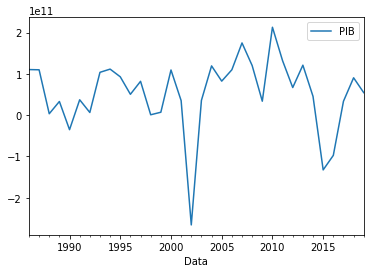

In [156]:
pib_diff = pib.diff(1).dropna()
pib_diff.plot()

In [157]:
adf_test(pib_diff)

Results of Dickey-Fuller Test:
Test Statistic                 -4.169681
p-value                         0.000741
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


Desta forma, é possível considerar que a nova série já está estacionada.

## Autocorrelação e autocorrelação parcial

A autocorrelação mostra o quanto o termo $t$ têm de influência dos termos $t-1, t-2, \dots, t-n$. Geralmente os termos mais próximos são mais fortes na autocorrelação. 

Na autocorrelação parcial estimamos um coeficiente direto $\beta$ de modo que $Y_t = \beta Y_{t-n}$, de modo generalizado. Assim, esta é mais sensível ao termo defasado do que a correlação entre termos.  

In [158]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


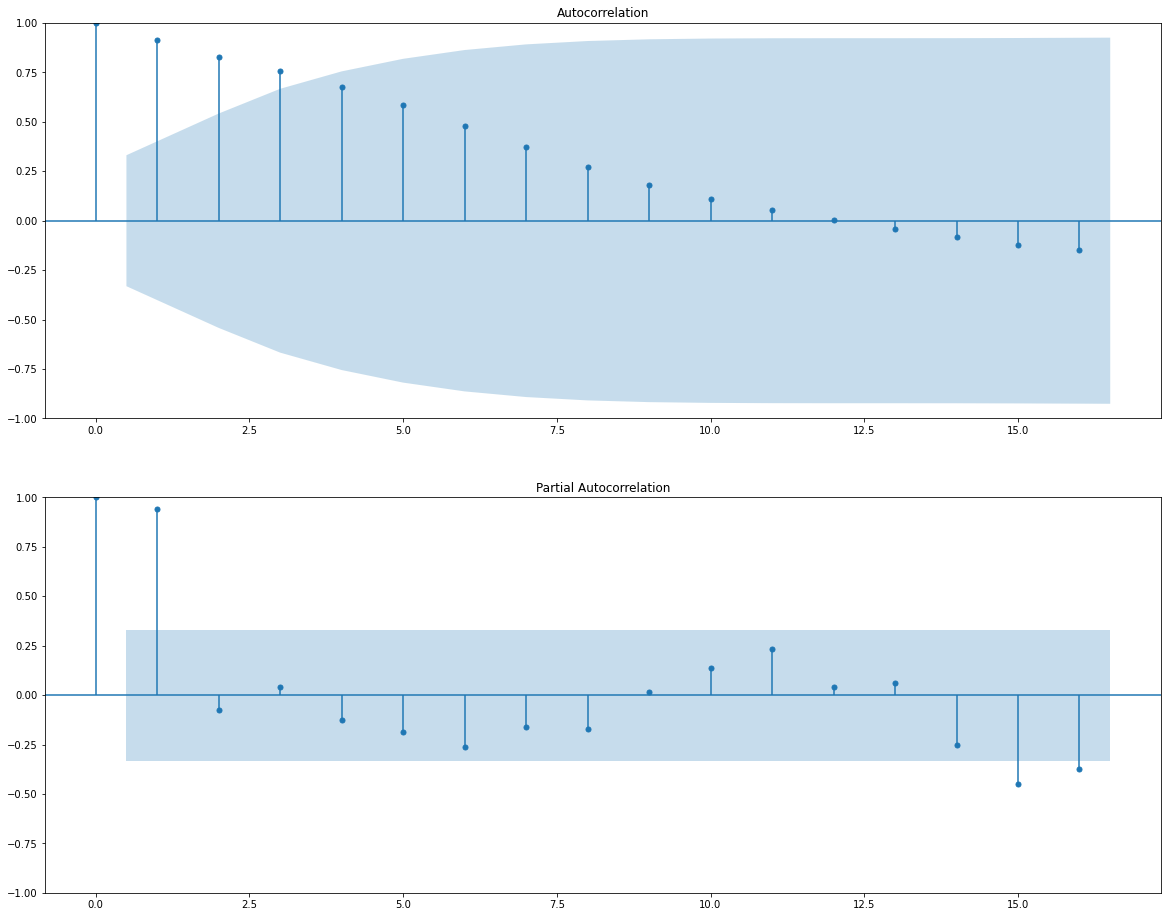

In [159]:
fig, ax = plt.subplots(nrows=2, ncols=1, 
                       figsize=(20, 16))
plot_acf(pib, ax=ax[0]);
plot_pacf(pib, ax=ax[1]);

C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


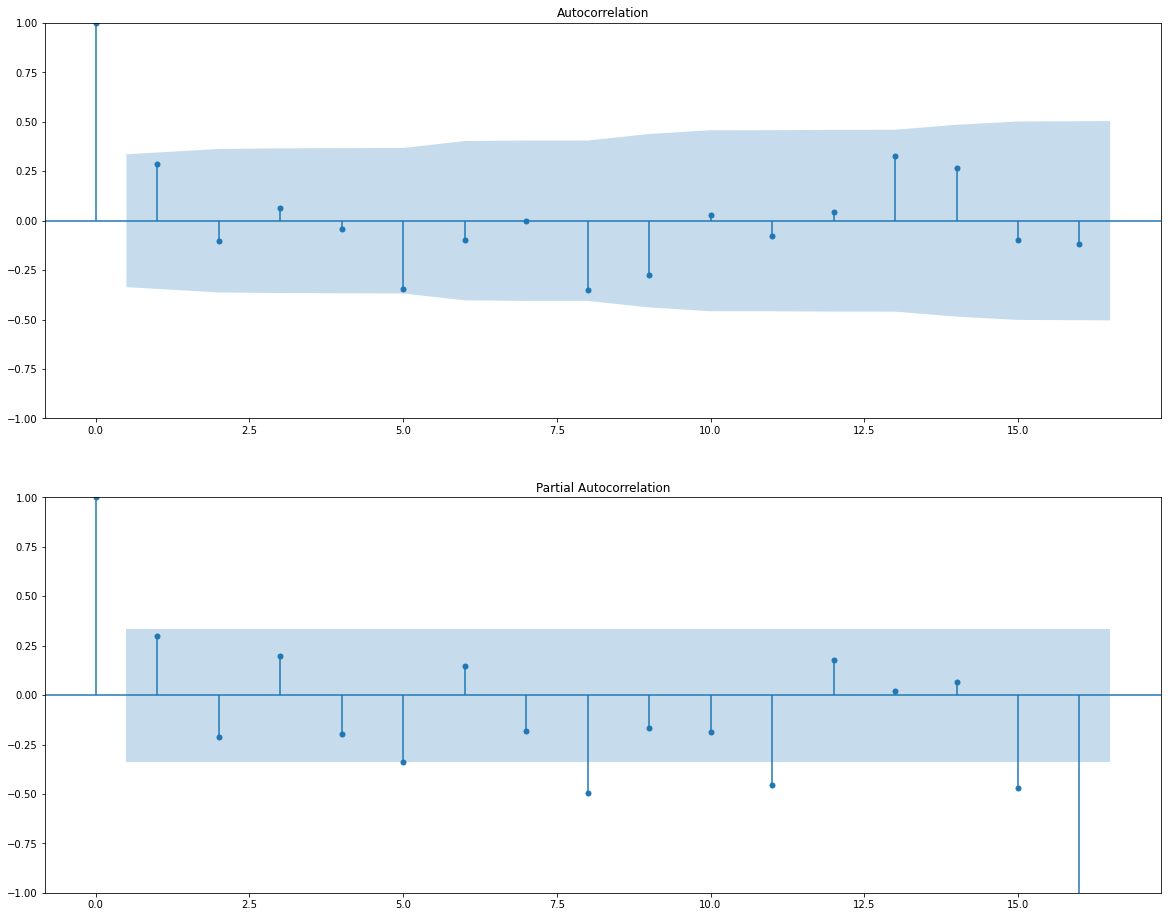

In [160]:
fig, ax = plt.subplots(nrows=2, ncols=1, 
                       figsize=(20, 16))
plot_acf(pib_diff, ax=ax[0]);
plot_pacf(pib_diff, ax=ax[1]);

## Modelos ARIMA

ARIMA (_AutoRegressive Integrated Moving Average_) é um modelo que junta os modelos autorregressivos e de média móvel (ARMA) com o grau de diferenciação (em quantas diferenças a série fica estacionária). Com este modelo, pode-se considerar que o grau é zero - $I(0)$. 

### Modelo autorregressivo

É um modelo em que o valor presente depende em algum grau do valor passado (ou valores passados). Genericamente tem-se, para o grau $p$, a fórmula
$$Y_t = c + \phi_1Y_{t-1} + \phi_2Y_{t-2} + \dots + \phi_pY_{t-p} + \epsilon_t$$

### Modelo de média móvel

É um modelo que o componente atual depende do erro aleatório do período passado. 

A fórmula para MA de grau $q$ é
$$Y_t = \mu + \epsilon_t + \theta_1\epsilon_{t-1} + \theta_2\epsilon_{t-2} + \dots + \theta_q\epsilon_{t-q}$$

### Modelo ARMA

É a junção dos dois modelos.

$$Y_t = c + \phi_1Y_{t-1} + \phi_2Y_{t-2} + \dots + \phi_pY_{t-p} + \theta_1\epsilon_{t-1} + \theta_2\epsilon_{t-2} + \dots + \theta_q\epsilon_{t-q} + \epsilon_t $$

Que pode ser reescrito para:

$$Y_t = c + \sum_{i=1}^p \phi_iY_{t-i} + \sum_{j=1}^q \theta_j\epsilon_{t-j} + \epsilon_t$$

Os modelos ARIMA são testados caso a caso.

In [222]:
from statsmodels.tsa.arima.model import ARIMA

arima = ARIMA(pib, order=(1, 1, 1))
modelo = arima.fit()
print(modelo.summary())

                               SARIMAX Results                                
Dep. Variable:                    PIB   No. Observations:                   35
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -905.430
Date:                Sat, 13 Aug 2022   AIC                           1816.861
Time:                        21:00:04   BIC                           1821.440
Sample:                    01-01-1985   HQIC                          1818.422
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9985      0.043     23.232      0.000       0.914       1.083
ma.L1         -0.9905      0.141     -7.002      0.000      -1.268      -0.713
sigma2      8.635e+21   7.87e-25    1.1e+46      0.0

C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


### Como escolher o melhor modelo

O melhor modelo seria aquele com menores índices de informação AIC e BIC. Quanto maiores estes valores, disponíveis no sumário do modelo, pior ajustado ele está em relação aos dados. **Menos é mais.**

In [223]:
orders = (
    (1, 1, 1),
    (2, 1, 1),
    (3, 1, 1),
    (1, 1, 2),
    (1, 1, 3),
    (2, 1, 2),
    (2, 1, 3),
    (3, 1, 2),
    (1, 1, 0),
    (0, 1, 1)
)

def compare_models(y, orders):
    models = []
    for order in orders:
        model = ARIMA(y, order=order)
        resul = model.fit()
        models.append([order, resul.aic, resul.bic])
    df = pd.DataFrame(models, columns=["order", "aic", "bic"])
    return df.set_index("order").sort_values(by="aic")

models = compare_models(pib['PIB'], orders)

models

C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred fre

,aic,bic
order,,
"(1, 1, 1)",1816.860506,1821.439588
"(2, 1, 1)",1817.394911,1823.500353
"(1, 1, 2)",1817.952903,1824.058345
"(3, 1, 1)",1819.197602,1826.829405
"(1, 1, 3)",1820.619331,1828.251134
"(2, 1, 2)",1820.690806,1828.322608
"(1, 1, 0)",1821.235180,1824.287901
"(0, 1, 1)",1821.377283,1824.430004
"(2, 1, 3)",1821.958699,1831.116862


Dessa forma pode-se ver que o modelo simples de order P,Q(1,1) é o que possui melhor resultado. 

Porém, é possível utilizar a função `auto_arima` do pacote pmdarima para identificar qual seria o melhor modelo também.

In [217]:
modelo_auto = pm.auto_arima(pib.PIB, 
                            start_p=1, start_q=1,
                            test='adf',
                            max_p=5, max_q=5,
                            m=1,
                            d=None,
                            seasonal=False,
                            start_P=0,
                            D=0,
                            trace=True,
                            error_action='ignore', 
                            suppress_warnings=True, 
                            stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1772.822, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1773.107, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1774.906, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=1774.930, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1771.174, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.131 seconds


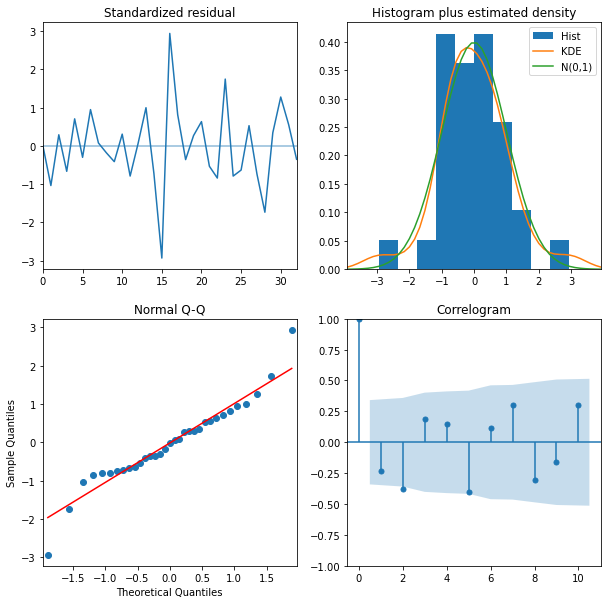

In [241]:
modelo_auto.plot_diagnostics(figsize=(10, 10));

<Figure size 1080x720 with 0 Axes>

Text(0.5, 1.0, 'Previsão do PIB')

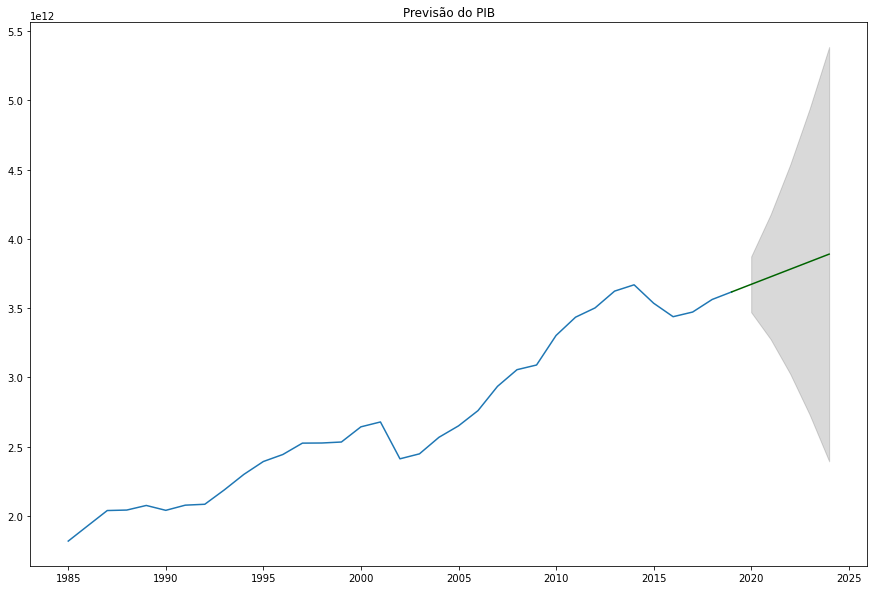

In [413]:
n_periods = 5
fc, confint = modelo_auto.predict(n_periods=n_periods, return_conf_int=True)

pib_with_fc = pib.copy()
for n in range(1, n_periods+1):
    new_date = pib.iloc[[-1]].index + timedelta(days=365*n)
    pib_with_fc = pd.concat([pib_with_fc,
                             pd.DataFrame(data=fc[n-1], 
                                          index=[new_date[0]], 
                                          columns=['PIB'])])

lower_series = pd.Series(confint[:, 0], index=pib_with_fc.index[-5:])
upper_series = pd.Series(confint[:, 1], index=pib_with_fc.index[-5:])


# Plot
plt.figure(figsize=(15, 10))
plt.plot(pib.PIB)
plt.plot(pib_with_fc.iloc[-6:, :], color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Previsão do PIB")
plt.show()

In [340]:
canada = pd.read_csv('dados/dataset_canada.csv')
canada['tempo'] = pd.to_datetime(canada['tempo'])
canada.set_index('tempo', inplace=True)
canada

,empregados_a_cada_1000_pessoas,produtividade_do_trabalho,salario_real,taxa_de_desemprego
tempo,,,,
1980-01-01,929.610514,405.366466,386.136109,7.53
1980-04-01,929.803985,404.639834,388.135759,7.70
1980-07-01,930.318388,403.814883,390.540113,7.47
1980-10-01,931.427687,404.215773,393.963817,7.27
1981-01-01,932.662006,405.046714,396.764691,7.37
...,...,...,...,...
1999-10-01,959.488142,415.701580,467.702562,6.93
2000-01-01,960.362493,416.867407,469.134788,6.80
2000-04-01,960.783379,417.610399,469.336420,6.70


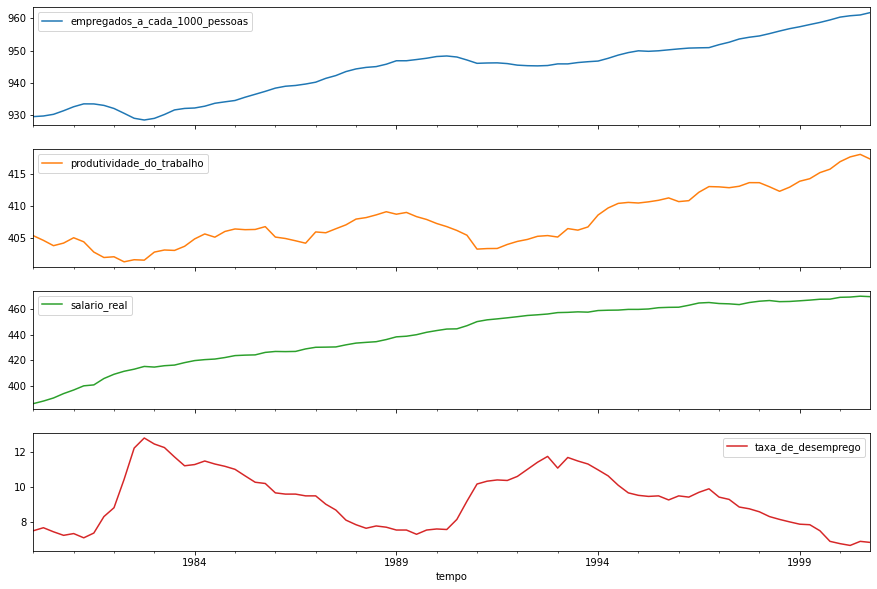

In [366]:
canada.plot(subplots=True, figsize=(15, 10));